# BERTopic Model Exploration

This notebook allows you to explore the trained BERTopic model, visualize clusters, and inspect specific reviews.

In [1]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append(os.path.abspath('../src'))

import numpy as np
import polars as pl
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP

from voc.storage.factory import get_storage
from voc.storage.types import StorageType

In [2]:
# Configuration
APP_ID = "2393760"

## 1. Load Data

We will load the pre-computed embeddings and the original reviews.

In [ ]:
def load_data(app_id):

    print(f"Loading embeddings for {app_id}...")
    emb_storage = get_storage(StorageType.PARQUET, app_id, base_path="../data/embeddings")
    emb_data = emb_storage.load()
    
    docs = [item["sentence"] for item in emb_data]
    embeddings = np.array([item["embedding"] for item in emb_data])
    
    print(f"Loaded {len(docs)} sentences and embeddings.")
    

    print(f"Loading original reviews for {app_id}...")
    review_storage = get_storage(StorageType.PARQUET, app_id, base_path="../data/reviews")
    reviews_data = review_storage.load()
    reviews_df = pl.DataFrame(reviews_data)
    
    print(f"Loaded {len(reviews_df)} reviews.")
    
    return docs, embeddings, reviews_df

docs, embeddings, reviews_df = load_data(APP_ID)

Loading embeddings for 2393760...
2026-02-01 19:49:39,809 - voc.storage.parquet_store - INFO - Loading 1 parquet files from ../data/embeddings/2393760
Loaded 1375 sentences and embeddings.
Loading original reviews for 2393760...
2026-02-01 19:49:39,932 - voc.storage.parquet_store - INFO - Loading 1 parquet files from ../data/reviews/2393760
Loaded 497 reviews.


## 2. Load Model

We will try to load the latest trained model from `data/models`.

In [ ]:
def load_latest_model(app_id):
    models_dir = Path("../data/models")
    candidates = sorted([d for d in models_dir.iterdir() if d.is_dir() and d.name.startswith(app_id)])
    
    if not candidates:
        raise FileNotFoundError(f"No models found for app {app_id}")
    
    latest_model_path = candidates[-1]
    print(f"Loading model from {latest_model_path}...")
    

    topic_model = BERTopic.load(str(latest_model_path), embedding_model=SentenceTransformer("all-MiniLM-L6-v2"))
    return topic_model

try:
    topic_model = load_latest_model(APP_ID)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Failed to load model: {e}")
    print("Training a new model temporarily for exploration...")
    topic_model = BERTopic(embedding_model=SentenceTransformer("all-MiniLM-L6-v2")).fit(docs, embeddings)


Loading model from ../data/models/2393760_20260201_194451...
2026-02-01 19:49:40,021 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cuda:0
2026-02-01 19:49:40,021 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded successfully.


## 2.5 Sentiment Analysis

We will calculate the sentiment (POSITIVE/NEGATIVE) for each sentence using a pre-trained Transformer model. 
This allows us to explore topics based on document sentiment.

In [ ]:
from transformers import pipeline
import pandas as pd
import torch


device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {device}")


model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path, device=device)

print(f"Calculating sentiment for {len(docs)} sentences...")


sentiments = sentiment_pipeline(docs, batch_size=32)


def map_label(label):
    l = label.lower()
    if 'negative' in l: return 'NEGATIVE'
    if 'neutral' in l: return 'NEUTRAL'
    if 'positive' in l: return 'POSITIVE'
    return label


sentiment_labels = [map_label(s['label']) for s in sentiments]
sentiment_scores = [s['score'] for s in sentiments]


sentiment_df = pd.DataFrame({
    'Document': docs,
    'Sentiment': sentiment_labels,
    'Score': sentiment_scores
})

print("Sentiment calculation complete.")
print(sentiment_df['Sentiment'].value_counts())

Using device: 0


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Calculating sentiment for 1375 sentences...
Sentiment calculation complete.
Sentiment
POSITIVE    1062
NEUTRAL      240
NEGATIVE      73
Name: count, dtype: int64


## 3. Visualization

Visualize the documents and clusters.

In [ ]:
fig = topic_model.visualize_documents(docs, embeddings=embeddings)
fig.show()

## 4. Explore Topics

List the top topics found.

In [10]:
topic_model

In [6]:
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

   Topic  Count                                        Name  \
0     -1    400                 -1_game_silly_fun_mechanics   
1      0     50               0_trails_tall_short_seriously   
2      1     46  1_platformer_platforming_platformers_solid   
3      2     37          2_ng_replayability_mode_randomizer   
4      3     34            3_joy_delightful_joyful_absolute   
5      4     34                       4_guys_guy_lil_little   
6      5     32             5_golem_golems_purpose_sorcerer   
7      6     30        6_climbing_climb_stamina_exploration   
8      7     29                                   7_ps_oh__   
9      8     28              8_worth_price_cheap_absolutely   

                                      Representation  Representative_Docs  
0  [game, silly, fun, mechanics, just, vibes, rea...                  NaN  
1  [trails, tall, short, seriously, world, yum, l...                  NaN  
2  [platformer, platforming, platformers, solid, ...                  NaN  
3 

## Plot sentiment

Plotting sentiment percentages for Topic 0...


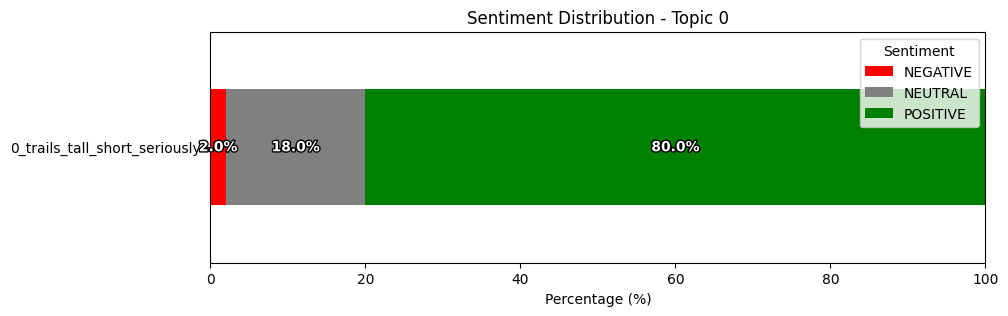

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

#Example topic
topic_id = 0

doc_info = topic_model.get_document_info(docs)
doc_info['Sentiment'] = sentiment_labels


topic_data = doc_info[doc_info['Topic'] == topic_id]
topic_name = topic_data.iloc[0]["Name"]

print(f"Plotting sentiment percentages for Topic {topic_id}...")


sentiment_counts = topic_data['Sentiment'].value_counts()


custom_order = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
sentiment_counts = sentiment_counts.reindex(custom_order, fill_value=0)


total = sentiment_counts.sum()
sentiment_pcts = (sentiment_counts / total) * 100


df_plot = pd.DataFrame([sentiment_pcts], index=[topic_name])


ax = df_plot.plot(
    kind='barh', 
    stacked=True, 
    color=['red', 'gray', 'green'],
    figsize=(10, 3) 
)


plt.title(f'Sentiment Distribution - Topic {topic_id}')
plt.xlabel('Percentage (%)')
plt.xlim(0, 100)


for c in ax.containers:
    # bar_label returns a list of Text objects
    labels = ax.bar_label(c, fmt='%.1f%%', label_type='center', color='white', weight='bold')
    # Apply path effects to each label to create the border/outline
    for label in labels:
        label.set_path_effects([pe.withStroke(linewidth=2, foreground="black")])

plt.show()
